# Detection of Bruxism events in Tinnitus patients polysomnographic data
This notebook will 
- load EMG channels of polusomnographic data
- detect the EMG bursts in a unsupervised way
- classify EMG bursts as different bruxism events
- give insights on the bruxism events

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import mne
import scipy
import seaborn as sns
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.check_impedance import create_annotation_mne, Impedance_thresholding_sliding, check_RMS, fuse_with_classif_result
from tinnsleep.signal import rms
from tinnsleep.visualization import plotTimeSeries, plotAnnotations, zoom_effect
from IPython.core.display import display
from ipywidgets import widgets
print("Config loaded")

print(Config.bruxisme_files[:3])

Config loaded
['/Users/louis/Data/SIOPI/bruxisme/1BA07_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1BA07_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1CC05_nuit_hab.edf']


## Load, filter, and prepare data

Extracting EDF parameters from /Users/louis/Data/SIOPI/bruxisme/1CC05_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-2-c57c7a3043d4>:4: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


Data filtered
keeping 7.27 hours of recording out of 8.82 hours
0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

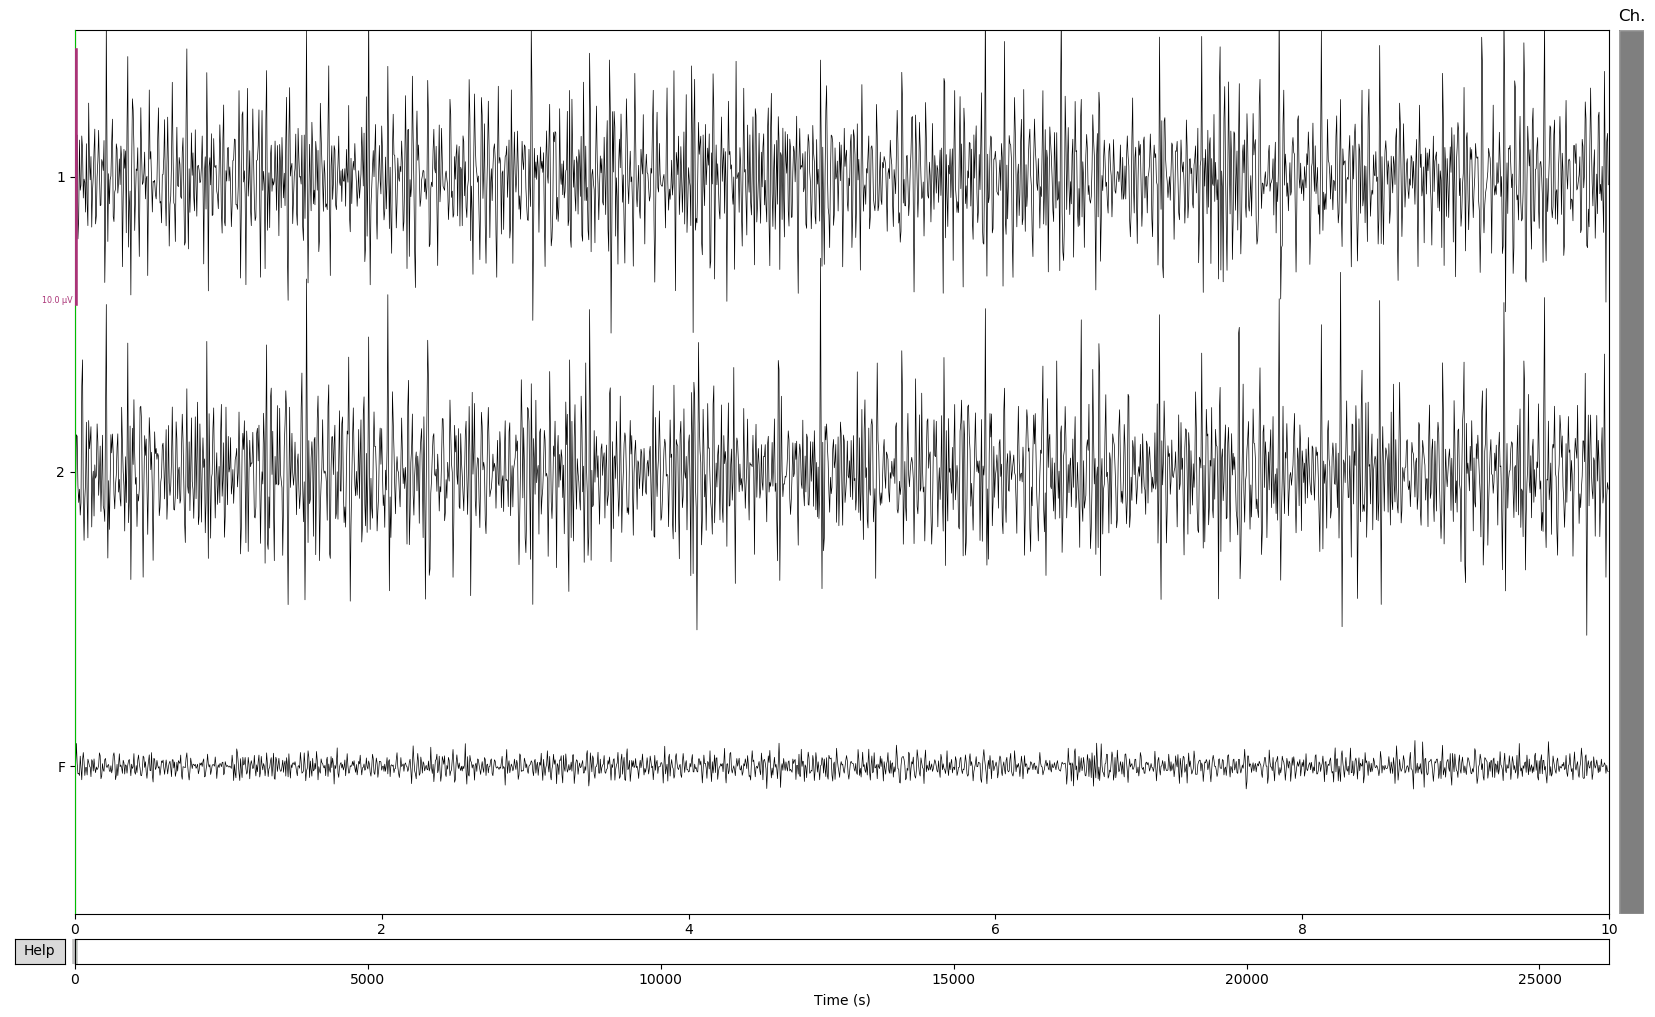

In [2]:
filename = Config.bruxisme_files[2]  # load file from config
picks_chan = ['1', '2', 'F']           # subset of EMG electrodes

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
tmin = raw.times[0]                     
tmax = raw.times[-1]

croptimes=dict(tmin=raw.times[0]+3600*2, tmax=raw.times[-1]-3600)
raw.crop(**croptimes)

raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types='emg')        # pick channels and load

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=picks_chan)
ch_names = raw.info["ch_names"]
print("Data filtered")

offset = raw.times[0]
print(f"keeping {(raw.times[-1]-raw.times[0])/3600:0.2f} hours of recording out of {(tmax-tmin)/3600:0.2f} hours")
print(offset)
raw.plot(scalings=dict(emg=5e-6))

## Epoching data

In [3]:
sfreq = raw.info["sfreq"]
window_length = 0.25                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape}")


Epochs done, shape (104750, 3, 50)


## Get the impedance & artefacts annotations

In [4]:
# Value of the impedance threshold
THR_imp = 6000

raw_imp  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
ch_names = raw_imp.info["ch_names"]
picks_chan = [ch_names[1],ch_names[5]]
print(picks_chan)

croptimes=dict(tmin=raw_imp.times[0]+3600*2, tmax=raw_imp.times[-1]-3600)
raw_imp.crop(**croptimes)

#Get the table of bad electrodes booleans from the impedance thresholding algo
check_imp  = Impedance_thresholding_sliding(raw_imp[picks_chan][0], duration, interval,THR_imp) 
print(check_imp[:3])

# convert to labels per epoch
impedance_labels = np.any(check_imp, axis=-1)
print(f"rejected impedances for {np.sum(impedance_labels)} epochs out of {len(impedance_labels)} ({np.sum(impedance_labels)/len(impedance_labels)*100:.2f}%)")

Extracting EDF parameters from /Users/louis/Data/SIOPI/bruxisme/1CC05_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
['1 Impedance', '2 Impedance']


<ipython-input-4-9f8560d7ccd5>:4: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw_imp  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


[[False False]
 [False False]
 [False False]]
rejected impedances for 0 epochs out of 104750 (0.00%)


In [5]:
# baseline epochs amplitudes
print(f"mean {np.mean(np.mean(epochs, axis=0), axis=-1)}")
print(f"median {np.median(np.median(epochs, axis=0), axis=-1)}")
print(f"quantile 0.05 {np.quantile(np.quantile(epochs, 0.05, axis=0),0.05, axis=-1)}")
print(f"quantile 0.95 {np.quantile(np.quantile(epochs, 0.95, axis=0),0.95, axis=-1)}")

mean [9.15127435e-13 9.49073052e-13 1.42247707e-13]
median [-1.41426379e-08 -2.08295327e-08  1.64944622e-10]
quantile 0.05 [-5.62643559e-06 -5.04297239e-06 -4.93799064e-07]
quantile 0.95 [6.07102657e-06 5.51880382e-06 4.94718466e-07]


In [6]:
# Epoch rejection based on |min-max| thresholding 
from tinnsleep.signal import is_good_epochs
params = dict(ch_names=raw.info["ch_names"],
             rejection_thresholds=dict(emg=5e-04), # two order of magnitude higher q0.01
             flat_thresholds=dict(emg=1e-09),    # one order of magnitude lower median
             channel_type_idx=dict(emg=[0, 1]),
             full_report=True
            )
amplitude_labels, bad_lists = is_good_epochs(epochs, **params)
print(amplitude_labels[:10])
print(bad_lists[:10])
print(f"good amplitudes for {np.sum(amplitude_labels)} epochs out of {len(amplitude_labels)} ({np.sum(amplitude_labels)/len(amplitude_labels)*100:.2f}%)")

[True, True, True, True, True, True, True, True, True, True]
[None, None, None, None, None, None, None, None, None, None]
good amplitudes for 104714 epochs out of 104750 (99.97%)


In [7]:
# Merge is_good and amplitude
# Logical OR
valid_labels = np.all(np.c_[np.invert(impedance_labels), amplitude_labels], axis=-1)

print(np.sum(valid_labels))
print(f"good epochs for {np.sum(valid_labels)} epochs out of {len(valid_labels)} ({np.sum(valid_labels)/len(valid_labels)*100:.2f}%)")
print(len(valid_labels))
print(valid_labels[:3])

dict_annotations_artefacts = {1: "artefact"}
annotations_artefacts = []
for k, label in enumerate(np.invert(valid_labels)):
    if label > 0:
        annotations_artefacts.append(dict(
            onset=k*interval/sfreq,
            duration=duration/sfreq,
            description=dict_annotations_artefacts[label],
            orig_time=offset
        )
            
        )

104714
good epochs for 104714 epochs out of 104750 (99.97%)
104750
[ True  True  True]


## Classifying epochs and annotate raw

In [8]:
# compute the sum of power over electrodes and samples in each window
epochs_adaptive = int(60 / window_length) # in epochs
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=2, n_adaptive=epochs_adaptive)
X        = rms(epochs[valid_labels]) # take only valid labels
labels   = pipeline.fit_predict(X)
labels   = fuse_with_classif_result(np.invert(valid_labels), labels) # add the missing labels removed with artefacts
print(f"bursts count: {np.sum(labels)}/{len(labels)} ({np.sum(labels) / len(labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(labels) * window_length} seconds")

dict_annotations = {1: "burst"}
annotations = []
for k, label in enumerate(labels):
    if label > 0:
        annotations.append(dict(
            onset=k*interval/sfreq,
            duration=duration/sfreq,
            description=dict_annotations[label],
            orig_time=offset
        )
            
        )

bursts count: 0/104750 (0.00%)
bursts time: 0.0 seconds


## Display Bursts

In [9]:
def plotBursts(raw, annotations, annotations_artefacts, plotargs):
    ax1 = plt.subplot(211)
    plotTimeSeries(raw.get_data().T, ax=ax1,**plotargs)
    plotAnnotations(annotations_artefacts, ax=ax1, color="red")
    plotAnnotations(annotations,ax=ax1, text_prop=dict(color="green"), color="green")

    ax1.set_xlim(5145,5165)
    ax2 = plt.subplot(212)
    plotTimeSeries(raw.get_data().T, ax=ax2,**plotargs)
    z = zoom_effect(ax1, ax2)

    from ipywidgets import interact, FloatSlider
    def update_axis(xmin, xmax):
        if xmin<xmax:
            ax1.set_xlim(xmin,xmax)

    i=FloatSlider(min=raw.times[0], max=raw.times[-1], step=10, continuous_update=False)
    ii=FloatSlider(min=raw.times[0], max=raw.times[-1], step=10, continuous_update=False)
    from ipywidgets import FloatSlider
    interact(update_axis,xmin=i, xmax=ii);
    return ax1, ax2

In [10]:
plt.close("all")

# decimate signal to make it more readible 
raw_ds = raw.copy().resample(100)

%matplotlib widget
scalings=1e-5
plotargs = dict(sfreq=raw_ds.info["sfreq"], scalings=scalings, offset=offset, linewidth=0.5)
plt.figure()
ax1, ax2 = plotBursts(raw_ds, annotations, annotations_artefacts, plotargs);
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='xmin', max=26187.49, step=1…

## Display Episodes

## Transform classif to episodes

1BA07_nuit_hab In this example, an episode of half an hour is detected between 1400 and 3500.

In [11]:
from tinnsleep.scoring import classif_to_burst, burst_to_episode
bursts = classif_to_burst(labels, time_interval=window_length)
annotations_episodes = [episode.generate_annotation(orig_time=offset) for episode in burst_to_episode(bursts)]
print(annotations_episodes[:3])

[]


In [12]:
#plt.close("all")
scalings=5e-5
print(offset)
plotargs = dict(sfreq=raw_ds.info["sfreq"], scalings=scalings, offset=offset, linewidth=0.5)
plt.figure()
plt.title("artefacts (red), episodes (green)")
ax3, ax4 = plotBursts(raw_ds, annotations_episodes, annotations_artefacts, plotargs)
ax3.set_xlim(10000,10200);
plt.show()

0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='xmin', max=26187.49, step=1…